# Basic regression: Predict fuel efficiency

This example uses the Keras API. (Visit the Keras [tutorials](https://www.tensorflow.org/tutorials/keras) and [guides](https://www.tensorflow.org/guide/keras) to learn more.)

In [1]:
# Use seaborn for pairplot.
#!pip install -q seaborn tensorflow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First download and import the dataset using pandas:

In [4]:
# load the og dataset
url = './fake_data_skewed.csv'
raw_dataset = pd.read_csv(url, na_values='?', skipinitialspace=True)

In [5]:
# look at the dataset
dataset = raw_dataset.copy()
print(dataset)

        li          si       lo          so  ao        po
0      0.0   35.000000   78.112   67.640500  12  3.343378
1      0.0   49.210526   78.112   82.608447  10  3.330189
2      0.0   63.421053   78.112   97.576395   9  3.318366
3      0.0   77.631579   78.112  112.544342   8  3.307956
4      0.0   91.842105   78.112  127.512289   7  3.299003
..     ...         ...      ...         ...  ..       ...
395  205.0  248.157895  281.636  292.159711 -16  2.761745
396  205.0  262.368421  281.636  307.127658 -18  2.782096
397  205.0  276.578947  281.636  322.095605 -20  2.804706
398  205.0  290.789474  281.636  337.063553 -22  2.829293
399  205.0  305.000000  281.636  352.031500 -24  2.855600

[400 rows x 6 columns]


## RELEVANT AGAIN

### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=2)
test_dataset = dataset.drop(train_dataset.index)


### Inspect the data

Review the joint distribution of parameters from the training set.

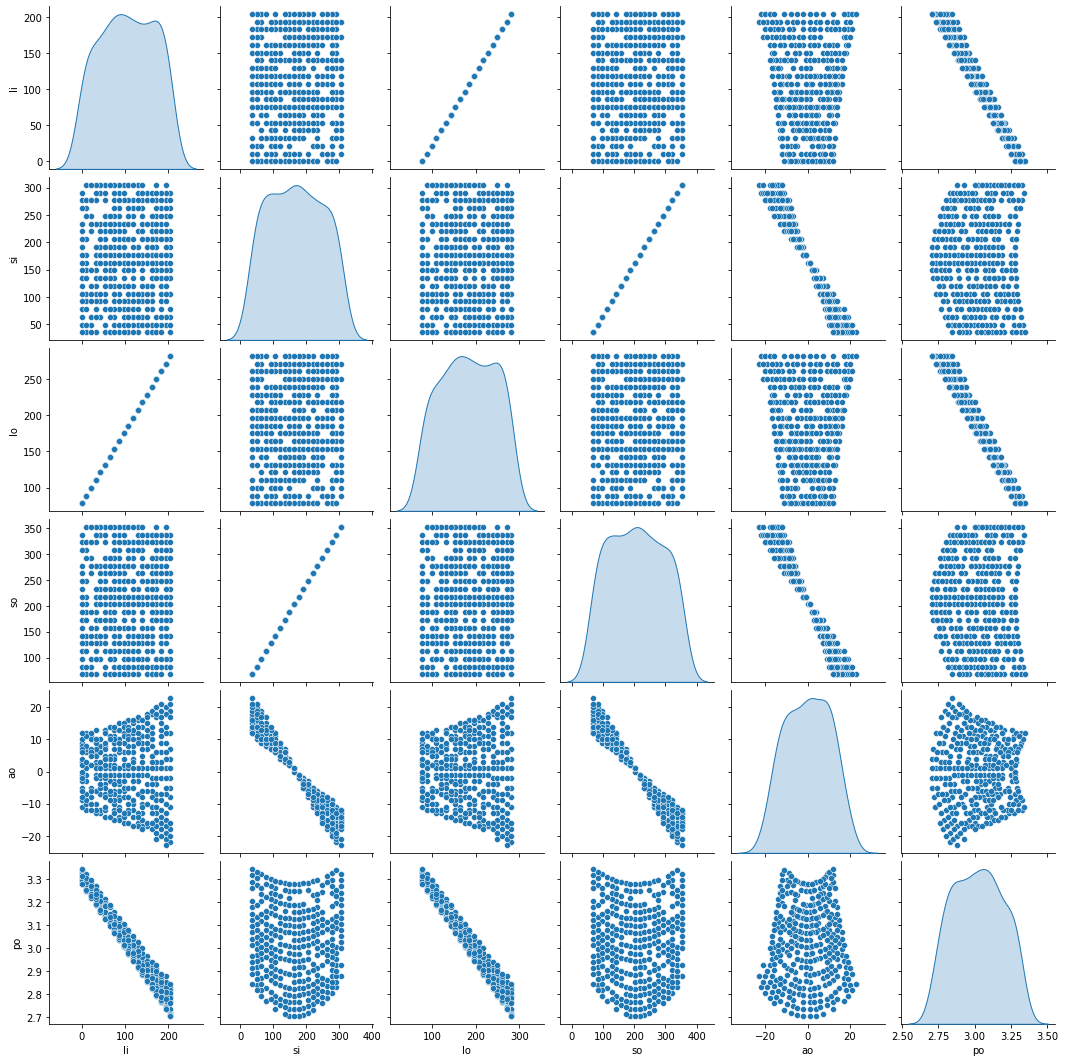

In [7]:
sns.pairplot(train_dataset[['li', 'si', 'lo', 'so','ao','po']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [8]:
train_dataset.describe()

,li,si,lo,so,ao,po
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,105.062500,167.513158,182.418050,207.216609,-0.021875,3.020516
std,62.054214,81.568094,61.607424,85.915673,10.553468,0.168883
min,0.000000,35.000000,78.112000,67.640500,-23.000000,2.703322
25%,53.947368,91.842105,131.670947,127.512289,-9.000000,2.878891
50%,107.894737,162.894737,185.229895,202.352026,1.000000,3.017754
75%,161.842105,233.947368,238.788842,277.191763,9.000000,3.156488
max,205.000000,305.000000,281.636000,352.031500,23.000000,3.343378


In [9]:
test_dataset.describe()

,li,si,lo,so,ao,po
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,92.250000,179.947368,169.697800,220.313563,-1.200000,3.057726
std,62.581773,83.701895,62.131184,88.163206,10.630027,0.167064
min,0.000000,35.000000,78.112000,67.640500,-24.000000,2.722826
25%,32.368421,106.052632,110.247368,142.480237,-10.000000,2.916103
50%,86.315789,191.315789,163.806316,232.287921,-3.500000,3.055873
75%,151.052632,251.710526,228.077053,295.901697,8.000000,3.215419
max,205.000000,305.000000,281.636000,352.031500,22.000000,3.350362


In [10]:
# data normalization
'''li_min = train_dataset['li'].min()
li_max = train_dataset['li'].max()

df = train_dataset.copy()

df['li'] = (df['li']-li_min)/(li_max-li_min)
print(df['li'])'''

"li_min = train_dataset['li'].min()\nli_max = train_dataset['li'].max()\n\ndf = train_dataset.copy()\n\ndf['li'] = (df['li']-li_min)/(li_max-li_min)\nprint(df['li'])"

In [11]:
train_dataset

,li,si,lo,so,ao,po
94,43.157895,233.947368,120.959158,277.191763,-7,3.176611
32,10.789474,205.526316,88.823789,247.255868,-3,3.253182
225,118.684211,106.052632,195.941684,142.480237,8,2.966276
157,75.526316,276.578947,153.094526,322.095605,-12,3.124435
356,183.421053,262.368421,260.212421,307.127658,-16,2.833884
...,...,...,...,...,...,...
224,118.684211,91.842105,195.941684,127.512289,10,2.977250
355,183.421053,248.157895,260.212421,292.159711,-14,2.815527
229,118.684211,162.894737,195.941684,202.352026,1,2.944962
308,161.842105,148.684211,238.788842,187.384079,3,2.826350


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [12]:
train_features = train_dataset[['li','si']].copy()
train_labels = train_dataset[['lo','so','ao','po']].copy()

In [13]:
test_features = test_dataset[['li','si']].copy()
test_labels = test_dataset[['lo','so','ao','po']].copy()

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
li,105.062500,62.054214
si,167.513158,81.568094
lo,182.418050,61.607424
so,207.216609,85.915673
ao,-0.021875,10.553468
po,3.020516,0.168883


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [16]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [17]:
print(normalizer.mean.numpy())

[[105.062 167.513]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [18]:
first = np.array(train_features[:10])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 43.16 233.95]
 [ 10.79 205.53]
 [118.68 106.05]
 [ 75.53 276.58]
 [183.42 262.37]
 [ 10.79 106.05]
 [ 32.37 134.47]
 [ 97.11 162.89]
 [161.84  91.84]
 [118.68 120.26]]

Normalized: [[-1.    0.82]
 [-1.52  0.47]
 [ 0.22 -0.75]
 [-0.48  1.34]
 [ 1.26  1.16]
 [-1.52 -0.75]
 [-1.17 -0.41]
 [-0.13 -0.06]
 [ 0.92 -0.93]
 [ 0.22 -0.58]]


## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [19]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(4, activation='relu'),
      layers.Dense(4, activation='relu'),
      layers.Dense(4, activation='relu'),
      layers.Dense(4, activation='relu'),
      layers.Dense(4)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [20]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense (Dense)               (None, 4)                 12        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                        

In [21]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=300)

Epoch 1/300
8/8 [==============================] - 1s 51ms/step - loss: 98.8361 - val_loss: 106.1958
Epoch 2/300
8/8 [==============================] - 0s 8ms/step - loss: 98.6049 - val_loss: 105.8200
Epoch 3/300
8/8 [==============================] - 0s 8ms/step - loss: 98.1377 - val_loss: 105.0483
Epoch 4/300
8/8 [==============================] - 0s 8ms/step - loss: 97.1229 - val_loss: 103.4536
Epoch 5/300
8/8 [==============================] - 0s 11ms/step - loss: 95.0563 - val_loss: 100.4690
Epoch 6/300
8/8 [==============================] - 0s 10ms/step - loss: 90.8589 - val_loss: 93.7360
Epoch 7/300
8/8 [==============================] - 0s 12ms/step - loss: 81.6997 - val_loss: 78.7926
Epoch 8/300
8/8 [==============================] - 0s 11ms/step - loss: 62.0330 - val_loss: 50.3880
Epoch 9/300
8/8 [==============================] - 0s 9ms/step - loss: 35.4362 - val_loss: 27.9404
Epoch 10/300
8/8 [==============================] - 0s 9ms/step - loss: 31.0260 - val_loss: 28.9613

8/8 [==============================] - 0s 9ms/step - loss: 1.8065 - val_loss: 2.3321
Epoch 84/300
8/8 [==============================] - 0s 10ms/step - loss: 1.9687 - val_loss: 2.0968
Epoch 85/300
8/8 [==============================] - 0s 8ms/step - loss: 1.8831 - val_loss: 2.3833
Epoch 86/300
8/8 [==============================] - 0s 10ms/step - loss: 1.8744 - val_loss: 2.3529
Epoch 87/300
8/8 [==============================] - 0s 9ms/step - loss: 2.0861 - val_loss: 2.9802
Epoch 88/300
8/8 [==============================] - 0s 9ms/step - loss: 2.1283 - val_loss: 2.2320
Epoch 89/300
8/8 [==============================] - 0s 9ms/step - loss: 1.9480 - val_loss: 2.5362
Epoch 90/300
8/8 [==============================] - 0s 10ms/step - loss: 1.8836 - val_loss: 2.1611
Epoch 91/300
8/8 [==============================] - 0s 9ms/step - loss: 1.8113 - val_loss: 1.8263
Epoch 92/300
8/8 [==============================] - 0s 12ms/step - loss: 2.1048 - val_loss: 2.4292
Epoch 93/300
8/8 [===========

Epoch 166/300
8/8 [==============================] - 0s 7ms/step - loss: 1.3159 - val_loss: 1.6267
Epoch 167/300
8/8 [==============================] - 0s 10ms/step - loss: 1.3602 - val_loss: 1.5693
Epoch 168/300
8/8 [==============================] - 0s 9ms/step - loss: 1.2667 - val_loss: 1.5738
Epoch 169/300
8/8 [==============================] - 0s 9ms/step - loss: 1.3158 - val_loss: 1.5776
Epoch 170/300
8/8 [==============================] - 0s 8ms/step - loss: 1.4963 - val_loss: 1.6549
Epoch 171/300
8/8 [==============================] - 0s 8ms/step - loss: 1.5424 - val_loss: 1.6549
Epoch 172/300
8/8 [==============================] - 0s 9ms/step - loss: 1.3369 - val_loss: 1.5609
Epoch 173/300
8/8 [==============================] - 0s 9ms/step - loss: 1.3248 - val_loss: 1.5258
Epoch 174/300
8/8 [==============================] - 0s 8ms/step - loss: 1.4665 - val_loss: 1.9611
Epoch 175/300
8/8 [==============================] - 0s 9ms/step - loss: 1.5032 - val_loss: 1.7734
Epoch 176

8/8 [==============================] - 0s 8ms/step - loss: 1.2605 - val_loss: 1.2153
Epoch 249/300
8/8 [==============================] - 0s 8ms/step - loss: 1.2671 - val_loss: 1.4179
Epoch 250/300
8/8 [==============================] - 0s 10ms/step - loss: 1.1864 - val_loss: 1.4447
Epoch 251/300
8/8 [==============================] - 0s 11ms/step - loss: 1.0818 - val_loss: 1.2116
Epoch 252/300
8/8 [==============================] - 0s 10ms/step - loss: 0.9785 - val_loss: 1.5292
Epoch 253/300
8/8 [==============================] - 0s 10ms/step - loss: 1.0823 - val_loss: 1.2317
Epoch 254/300
8/8 [==============================] - 0s 11ms/step - loss: 1.1269 - val_loss: 1.3616
Epoch 255/300
8/8 [==============================] - 0s 9ms/step - loss: 1.1303 - val_loss: 1.5217
Epoch 256/300
8/8 [==============================] - 0s 10ms/step - loss: 1.0715 - val_loss: 1.2426
Epoch 257/300
8/8 [==============================] - 0s 9ms/step - loss: 1.0312 - val_loss: 1.2420
Epoch 258/300
8/8 

In [22]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

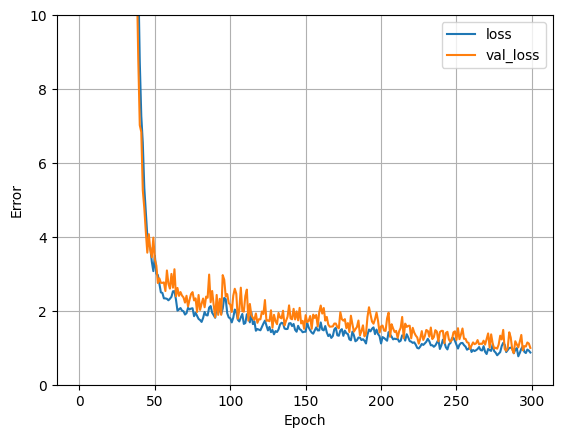

In [23]:
plot_loss(history)

Collect the results on the test set:

In [24]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(train_features, train_labels, verbose=1)

10/10 [==============================] - 0s 4ms/step - loss: 0.8805


### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

In [25]:
y = dnn_model.predict(train_features)

10/10 [==============================] - 0s 2ms/step


In [26]:
np.savetxt("prediction.csv", y, delimiter=",")

In [27]:
test_results['trained'] = dnn_model.evaluate(
    test_features, test_labels, verbose=1)

test_predictions = dnn_model.predict(test_features)

error = test_predictions - test_labels
print(error.abs())
print(error.abs().describe())

3/3 [==============================] - 0s 3ms/step
           lo        so         ao        po
15   0.174813  0.214825   4.431623  0.261847
19   3.317161  1.540655   5.650417  0.351848
22   1.305288  0.948950   0.560946  0.159337
26   0.933790  0.589886   0.820585  0.162976
31   0.469412  0.141095   2.797495  0.203509
..        ...       ...        ...       ...
363  0.094802  0.804932   3.740129  0.234106
384  0.264543  0.711999   4.082907  0.230896
386  0.450304  0.532468   2.273676  0.219761
394  1.193285  0.185660   7.963274  0.315618
399  1.657701  0.634466  10.986353  0.473968

[80 rows x 4 columns]
              lo         so         ao         po
count  80.000000  80.000000  80.000000  80.000000
mean    0.582224   0.512625   2.349584   0.251615
std     0.511024   0.467152   2.043111   0.073201
min     0.004913   0.016242   0.085855   0.159337
25%     0.221884   0.227647   0.836514   0.194125
50%     0.469355   0.461836   1.976336   0.231035
75%     0.880017   0.656528   3.2444

In [28]:
pd.concat(
    [test_features.copy(), error],
    axis=1)

,li,si,lo,so,ao,po
15,0.000000,248.157895,-0.174813,-0.214825,-4.431623,-0.261847
19,0.000000,305.000000,3.317161,-1.540655,-5.650417,-0.351848
22,10.789474,63.421053,-1.305288,0.948950,0.560946,-0.159337
26,10.789474,120.263158,-0.933790,0.589886,-0.820585,-0.162976
31,10.789474,191.315789,-0.469412,0.141095,-2.797495,-0.203509
...,...,...,...,...,...,...
363,194.210526,77.631579,0.094802,0.804932,-3.740129,-0.234106
384,205.000000,91.842105,0.264543,0.711999,-4.082907,-0.230896
386,205.000000,120.263158,0.450304,0.532468,-2.273676,-0.219761
394,205.000000,233.947368,1.193285,-0.185660,7.963274,-0.315618


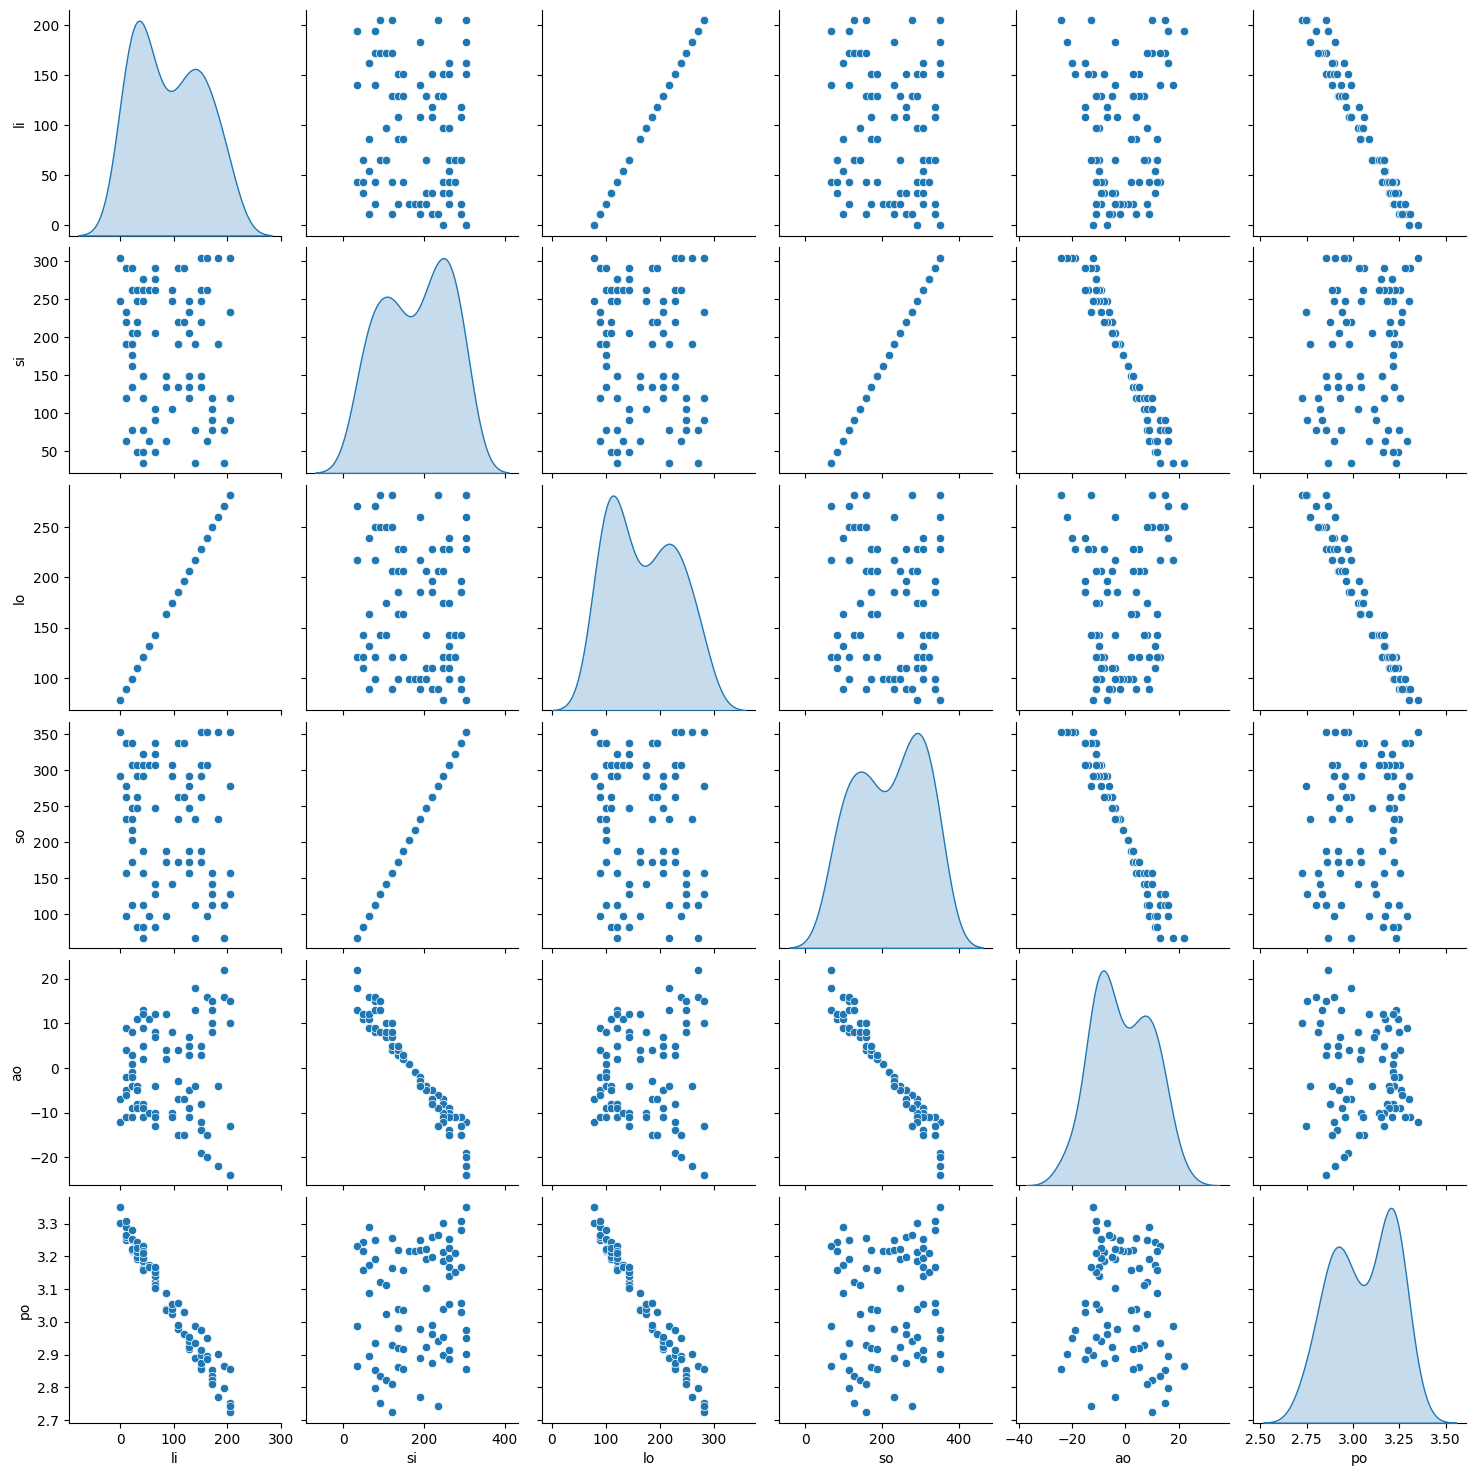

In [29]:
sns.pairplot(test_dataset[['li', 'si', 'lo', 'so','ao','po']], diag_kind='kde')

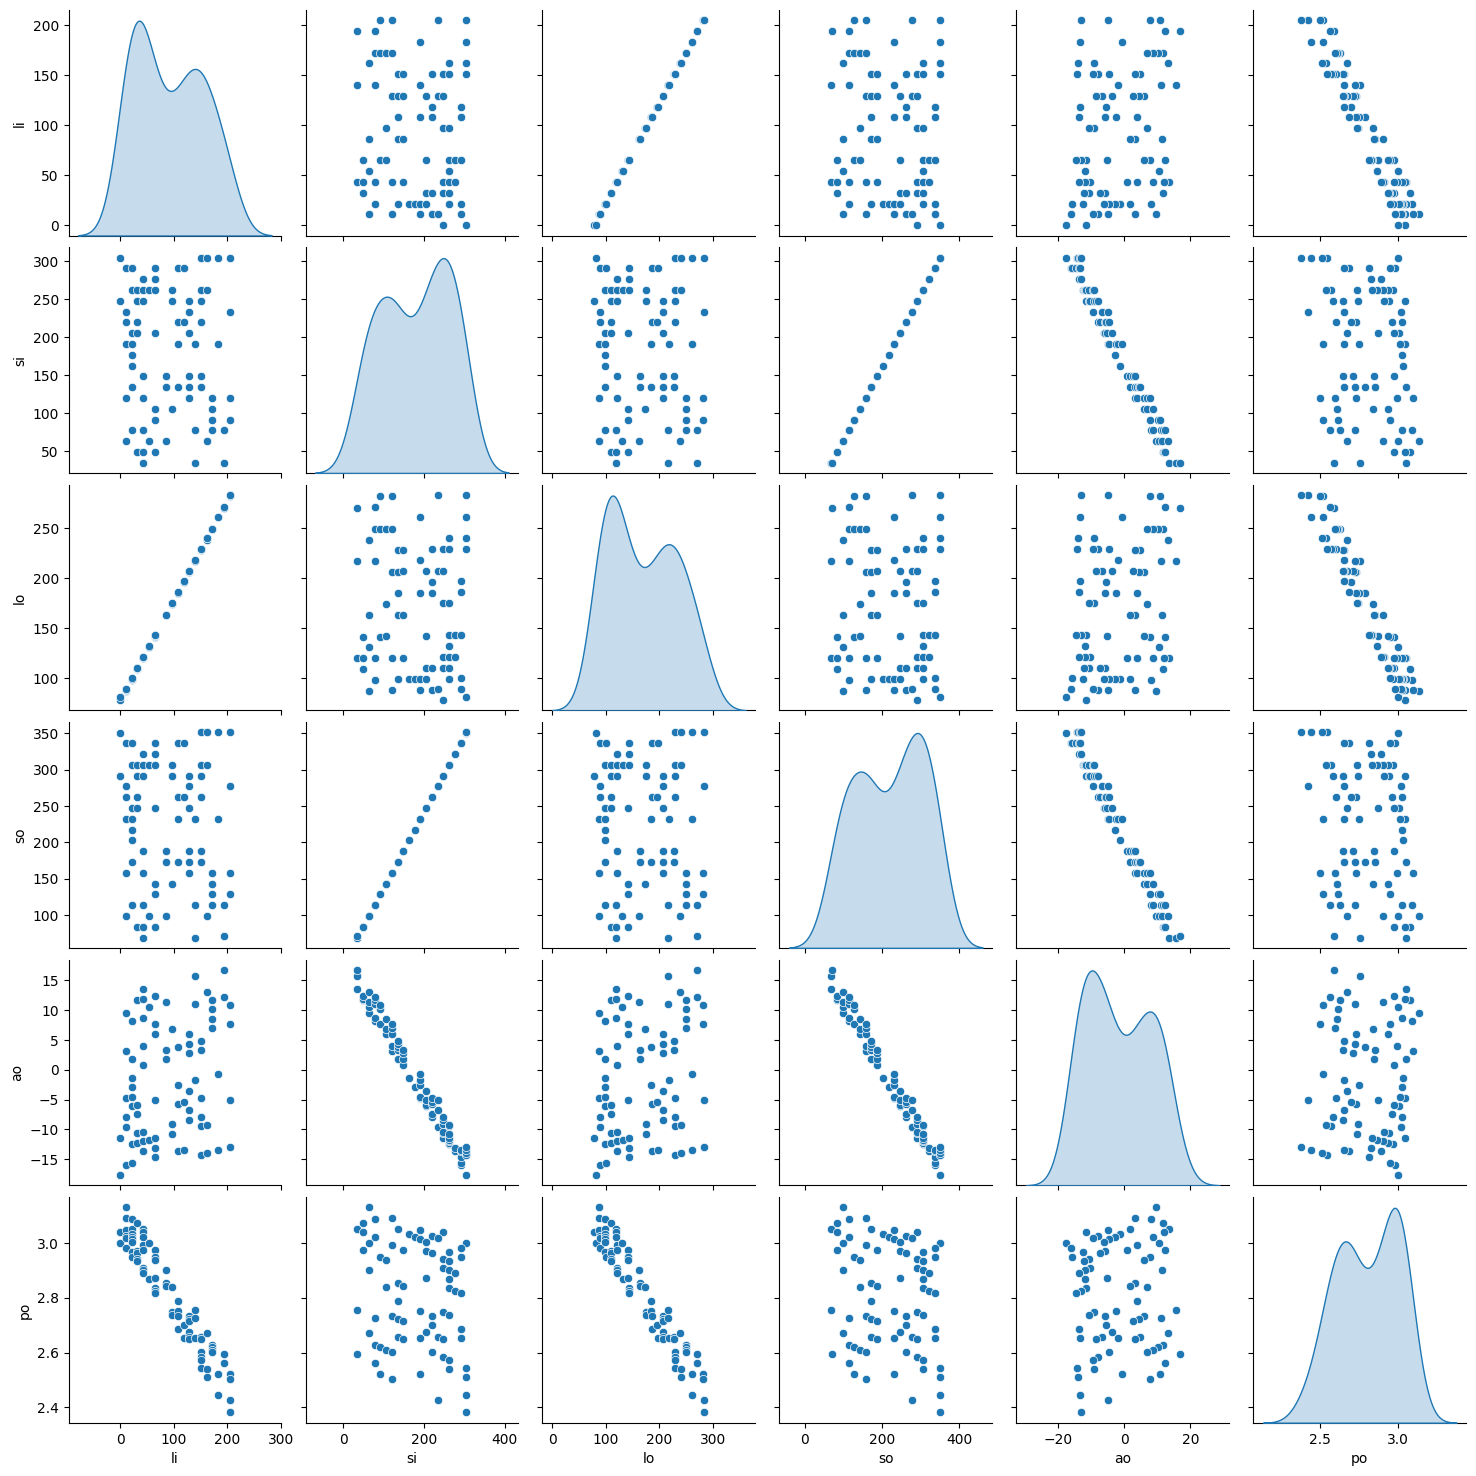

In [30]:
predictions = pd.DataFrame(test_predictions, columns = ['lo', 'so', 'ao', 'po'])
sns.pairplot(pd.concat(
    [test_features.copy().reset_index(), predictions],
    axis=1)[['li', 'si', 'lo', 'so','ao','po']], 
    diag_kind='kde')

### Save Model

If you're happy with the model, save it for later use with `Model.save`:

In [33]:
#dnn_model.save('dnn_model_two_layer_64')

### Reload Model

If you reload the model, it gives identical output:

In [34]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [35]:
test_predictions = reloaded.predict(test_features)

3/3 [==============================] - 0s 4ms/step


In [36]:
# test_case = [li,si]
test_case = [154.8,227.7]
prediction = reloaded.predict(test_case)
print(prediction)

1/1 [==============================] - 0s 156ms/step
[[217.935 236.76   -8.672   2.669]]


In [37]:
error = test_predictions - test_labels
'''plt.hist(error, bins=25)
plt.xlabel('Prediction Error [lo]')
_ = plt.ylabel('Count')'''
print(error)
print(error.describe())

            lo         so        ao        po
15   10.910423   4.181995 -0.118613  0.151801
19   32.883468  27.638941 -3.132224  0.460513
22   -4.906271  -2.178537 -0.039253 -0.083963
26   -5.284399  -5.128986  0.277801 -0.056971
31   -4.649526  -8.509860  0.494992 -0.053037
..         ...        ...       ...       ...
363  -7.442948 -43.355270  2.208157 -0.221856
384  -5.662764 -51.076689  0.931468 -0.271136
386  -5.914320 -69.106853  1.394401 -0.444472
394  -5.205977 -34.580908  2.919959 -0.008912
399  -1.318678   6.053980  0.253557  0.164794

[80 rows x 4 columns]
              lo         so         ao         po
count  80.000000  80.000000  80.000000  80.000000
mean  -11.324957 -23.494306   0.260872  -0.165070
std     9.429384  28.107034   2.879123   0.187988
min   -25.420228 -82.273882  -5.852875  -0.571103
25%   -17.472284 -44.011133  -1.564971  -0.265799
50%   -13.145514 -16.726234   0.642933  -0.148290
75%    -5.900070  -1.249280   2.201893  -0.053958
max    32.883468  27.6389

In [38]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
dnn_model,0.880457
trained,0.924012
reloaded,10.842381


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.